# School Budgeting with ML
School budgets in the United States are incredibly complex, and there are no standards for reporting how money is spent. Schools want to be able to measure their performance--for example, are we spending more on textbooks than our neighboring schools, and is that investment worthwhile? However to do this comparison takes hundreds of hours each year in which analysts hand-categorize each line-item. Our goal is to build a machine learning algorithm that can automate that process. For each line item, we have some text fields that tell us about the expense--for example, a line might say something like "Algebra books for 8th grade students". We also have the amount of the expense in dollars. This line item then has a set of labels attached to it. For example, this one might have labels like "Textbooks," "Math," and "Middle School." These labels are our target variable. This is a supervised learning problem where we want to use correctly labeled data to build an algorithm that can suggest labels for unlabeled lines. This is in contrast to an unsupervised learning problem where we don't have labels, and we are using an algorithm to automatically which line-items might go together. For this problem, we have <b>100 target labels</b>.

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

# import helper function
import school_budget_helper as helper

sns.set()

In [3]:
train_data = pd.read_csv('datasets/TrainingData.csv')
print(train_data.shape)
train_data.head(3)

(400277, 26)


,Unnamed: 0,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
0,134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.81,KINDERGARTEN,General Fund,NaN
1,206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.86,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
2,326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.13,Instruction - Regular,General Purpose School,NaN


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              400277 non-null  int64  
 1   Function                400277 non-null  object 
 2   Use                     400277 non-null  object 
 3   Sharing                 400277 non-null  object 
 4   Reporting               400277 non-null  object 
 5   Student_Type            400277 non-null  object 
 6   Position_Type           400277 non-null  object 
 7   Object_Type             400277 non-null  object 
 8   Pre_K                   400277 non-null  object 
 9   Operating_Status        400277 non-null  object 
 10  Object_Description      375493 non-null  object 
 11  Text_2                  88217 non-null   object 
 12  SubFund_Description     306855 non-null  object 
 13  Job_Title_Description   292743 non-null  object 
 14  Text_3              

## Visualize data
You'll notice that there are two numeric columns, called FTE and Total.

FTE: Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.
Total: Stands for the total cost of the expenditure. This number tells us how much the budget item cost.
After printing summary statistics for the numeric data, your job is to plot a histogram of the non-null FTE column to see the distribution of part-time and full-time employees in the dataset.

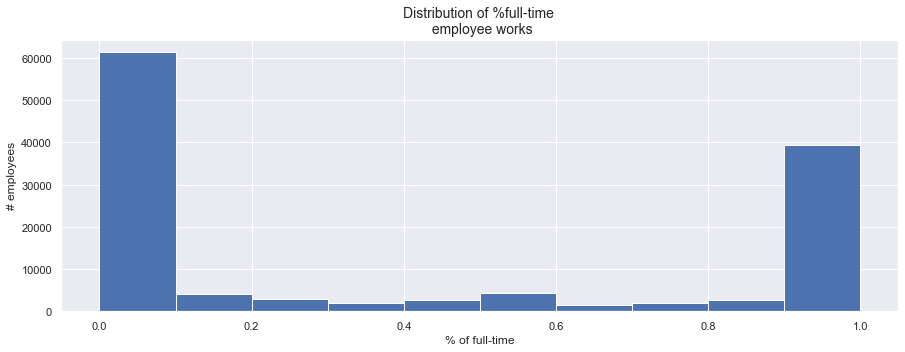

In [5]:
# set the figure size and title
plt.figure(figsize=(15, 5))
plt.title('Distribution of %full-time \n employee works', fontsize=14)

# create a histogram to show the %
plt.hist(train_data['FTE'].dropna(), range=(0, 1))

# set the labels
plt.xlabel('% of full-time')
plt.ylabel('# employees')
plt.show()

### Encode labels as categories
The first problem is that our machine learning algorithms work on numbers. We need a numeric representation of these strings before we can do any sort of model-fitting. The second problem is that strings can be slow. We never know ahead of time how long a string is, so our computers have to take more time processing strings than numbers, which have a precise number of bits. In pandas, there is a special datatype called category that encodes our categorical data numerically, and--because of this numerical encoding--it can speed up our code. In pandas, we can call the astype function with the string category to change a column's type from object to category.
* ML algorithm works on numbers, not strings -> need a numeric representation of strings
* Strings can be slow in comparison with numbers

In [6]:
# get the labels to change the dtype of
labels = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 
          'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']

# create a lambda function to apply type conversion
change_type = lambda x: x.astype('category')

train_data[labels] = train_data[labels].apply(change_type, axis=0)
print(train_data[labels].dtypes)

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


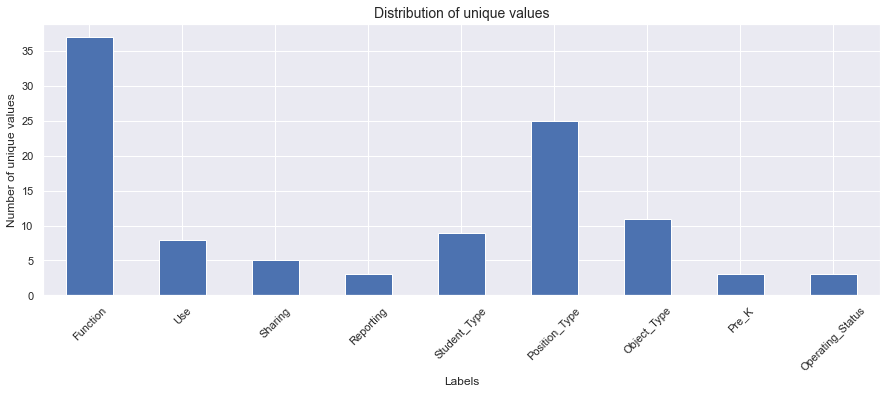

In [7]:
# calculate number of unique values for each label: num_unique_labels
num_unique_labels = train_data[labels].apply(pd.Series.nunique, axis=0)

# set the figure size and title
plt.figure(figsize=(15, 5))
plt.title('Distribution of unique values', fontsize=14)

# plot number of unique values for each label
num_unique_labels.plot(kind='bar')

# label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# rotate the x-values
plt.xticks(rotation=45)

# display the plot
plt.show()

### How do we measure success?
The next step is to decide how we decide if our algorithm works. Choosing how to evaluate your machine learning model is one of the most important decisions an analyst makes. The decision balances the real-world use of the algorithm, the mathematical properties of the evaluation function, and the interpretability of the measure. Often we hear the question "how accurate is your model?" Accuracy is a simple measure that tells us what percentage of rows we got right. However, sometimes accuracy doesn't tell the whole story. Consider the case of identifying spam emails. Let's say that only 1% of the emails I receive are spam. The other 99% are legitimate emails. I can build a classifier that is 99% accurate just by assuming every message is legitimate, and never marking any message as spam. But this model isn't useful at all because every message, even the spam, ends up in my inbox. The metric we use for this problem is called log loss. Log loss is what is generally called a "loss function," and it is a measure of error. We want our error to be as small as possible, which is the opposite of a metric like accuracy, where we want to maximize the value.

#### Log loss binary classification
$$logloss=-\frac{1}{N}\sum_{i=1}^N(y_i log(p_i) + (1-y_i)log(1-p_i))$$
* Actual value: y = {1=yes, 0=no}
* p: prediction (probability that the value is 1)

In [8]:
# create a helper function to calculate logloss
def compute_log_loss(predicted, actual, eps=1e-14):
    """
    Computes the logarithmic loss between predicted and actual when these are 1D arrays.
    
    Parameters:
        predicted: The predicted probabilities as floats between 0-1
        actual: The actual binary labels, either 0 or 1
        eps (optional): log(0) is inf, so we need to offset our 
                        predicted values slightly by eps from 0 or 1
    
    Returns:
        Log loss result 
    """
    predicted = np.clip(predicted, eps, 1 - eps)
    return -1 * np.mean(actual * np.log(predicted)) + (1 - actual) * np.log(1 - predicted)

# check the example predictions
print(compute_log_loss(0.9, 0))
print(compute_log_loss(0.5, 1))

-2.302585092994046
0.6931471805599453


## Time to build a model
#### Steps for Model 1
* Train basic model on numeric data only (to go from raw data to predictions quickly)
* Multi-class Logistic Regression: train classifier on each label separately and use those to predict
* Format predictions and save to csv 
* Compute logloss

In [9]:
numeric_columns = ['FTE', 'Total']
numeric_data_only = train_data[numeric_columns].fillna(-1000)
label_dummies = pd.get_dummies(train_data[labels])

# Create training and test sets
X_train, X_test, y_train, y_test = helper.multilabel_train_test_split(numeric_data_only, label_dummies,
                                                               size=0.2, seed=123)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 0 to 400276
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     320222 non-null  float64
 1   Total   320222 non-null  float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 4 to 400274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     80055 non-null  float64
 1   Total   80055 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 0 to 400276
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 4 to 400274
Columns: 104 entries, Function_Aides Compensa

## Not pretty results
Remember, we're ultimately going to be using logloss to score our model, so don't worry too much about the accuracy here. Keep in mind that you're throwing away all of the text data in the dataset - that's by far most of the data! So don't get your hopes up for a killer performance just yet. We're just interested in getting things up and running at the moment.

In [10]:
# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

Accuracy: 0.0


## Making predictions
Once our classifier is trained, we can use it to make predictions on new data. We could use our test set that we've withheld, but we want to simulate actually competing in a data science competition, so we will make predictions on the holdout set that the competition provides. As we did with our training data, we load the holdout data using the read_csv function from pandas. We then perform the same simple preprocessing we used earlier. First, we select just the numeric columns. Then we use fillna to replace NaN values with -1000.Finally, we call the predict_proba method on our trained classifier. Remember, we want to predict probabilities for each label, not just whether or not the label appears. If we simply used the predict method instead, we would end up with a 0 or 1 in every case. Because log loss penalizes you for being confident and wrong, the score for this submission would be significantly worse than if we use predict_proba.
* If .predict() was used instead, the output would be 0 or 1, and logloss would penalize being confident and wrong

Then, reformat the dataframe to pass to the competition submission.

In [11]:
# read the test data
test_data = pd.read_csv('datasets/TestData.csv')
test_data.head(3)

c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,Object_Description,Program_Description,SubFund_Description,Job_Title_Description,Facility_or_Department,Sub_Object_Description,Location_Description,FTE,Function_Description,Position_Extra,Text_4,Total,Text_2,Text_3,Fund_Description,Text_1
0,180042,Student Meals/Room/Other,Basic Educational Services,NaN,NaN,NaN,Line Item that is paid with Campus' money,School,NaN,Instruction,NaN,NaN,3999.910000,NaN,NaN,General Fund,NaN
1,28872,Extra Duty/Signing Bonus Pay,Undistributed,NaN,CHEERLEADER DIR,NaN,General,School,NaN,Cocurricular & Extra Curricular Activities,NaN,NaN,3447.320213,NaN,NaN,General Fund,NaN
2,186915,Professional Salaries,Bilingual Education,NaN,T-EL 1ST BIL,NaN,General,School,1.0,Instruction,NaN,NaN,52738.780869,NaN,NaN,General Fund,NaN


In [12]:
# fill the missing values & get the predictions
test_data = test_data[numeric_columns].fillna(-1000)
predictions = clf.predict_proba(test_data)

In [13]:
# reformat the dataframe 
predictions_df = pd.DataFrame(columns=pd.get_dummies(train_data[labels], prefix_sep='__').columns,
                             index=test_data.index, data=predictions)
predictions_df.head(3)

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Object_Type__Rent/Utilities,Object_Type__Substitute Compensation,Object_Type__Supplies/Materials,Object_Type__Travel & Conferences,Pre_K__NO_LABEL,Pre_K__Non PreK,Pre_K__PreK,Operating_Status__Non-Operating,"Operating_Status__Operating, Not PreK-12",Operating_Status__PreK-12 Operating
0,0.036436,0.006444,0.000820,0.020259,0.006421,0.000168,0.031728,0.024914,0.051970,0.000059,...,0.010719,0.037906,0.115584,0.017154,0.830936,0.141207,0.027858,0.167641,0.019894,0.810404
1,0.036437,0.006444,0.000820,0.020509,0.006504,0.000168,0.031729,0.024914,0.051970,0.000059,...,0.010719,0.037932,0.115584,0.017154,0.830930,0.141217,0.027858,0.168067,0.019894,0.810415
2,0.078814,0.008539,0.000497,0.233416,0.228242,0.000348,0.015160,0.013368,0.042337,0.000050,...,0.002085,0.129884,0.001852,0.002127,0.500609,0.498311,0.041173,0.428248,0.025170,0.962351


In [14]:
# Save prediction_df to csv
predictions_df.to_csv('predictions.csv')


### Submission results
<code>Your model, trained with numeric data only, yields logloss score: 1.9067227623381413</code>

## Introducing NLP 


In [15]:
def token(df, column, seq='[A-Za-z0-9]+(?=\s+)', print_results=True):
    """
    """
    # fill the missing data beforehand
    df[column].fillna('', inplace=True)
    
    # initialize CountVectorizer
    vect = CountVectorizer(token_pattern=seq)
    vect.fit(df[column])
    results = vect.get_feature_names()
    
    if print_results:
        print(f'There are {len(results)} tokens in {column} if tokens are any non-whitespace')
    
    return {
        'vectorizer': vect,
        'results': results
    }
    

_ = token(train_data, 'Program_Description', '\S+(?=\s+)')
_ = token(train_data, 'Position_Extra')

There are 434 tokens in Program_Description if tokens are any non-whitespace
There are 385 tokens in Position_Extra if tokens are any non-whitespace


## Pipelines, features & text representation

In [21]:
# create a pipeline
pipe = Pipeline([
    ('imp', SimpleImputer()),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

# split the data
X_train, X_test, y_train, y_test = train_test_split(train_data[numeric_columns], pd.get_dummies(train_data['Reporting']), 
                                                    test_size=0.2)
pipe.fit(X_train, y_train)
print(f'Test accuracy: {round(pipe.score(X_test, y_test), 3)}')

Test accuracy: 0.613


### Problems with multiple dtypes
When we're working with different dtypes, both imputation and text preprocessing can't be done together. We can't just have a Pipeline that has a CountVectorizer step, Imputation step, and then a classifier. The CountVectorizer won't know what to do with the numeric columns, and we don't want to perform imputation on the text columns. In order to build our pipeline, we need to separately operate on the text columns and on the numeric columns. <b>There are two tools</b>: <i>FunctionTransformer</i> and <i>FeatureUnion</i> that will help us build a Pipeline to work with both our text and numeric data. The first utility that we cover is the FunctionTransformer.

In [23]:
# example of how to work with FunctionTransformer & FeatureUnuin
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[['numeric', 'with_missing']], validate=False)

# preprocess numeric dtypes
numeric_pipeline = Pipeline([
    ('selector', get_numeric_data),
    ('imputer', SimpleImputer())
])

# preprocess categorical dtypes
text_pipeline = Pipeline([
    ('selector', get_text_data),
    ('vectorizer', CountVectorizer())
])

# create the final pipeline 
pipe = Pipeline([
    ('union', FeatureUnion([
        ('numeric', numeric_pipeline),
        ('text', text_pipeline)
    ])),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])